In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# for displaying purposes only
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.models import load_model

from keras.models import model_from_json

In [26]:
# load h5
model = load_model('old_dataset_old_tree.h5')

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load model from json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [27]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 48)        6960      
_________________________________________________________________
dense (Dense)                (None, 44, 44, 256)       12544     
_________________________________________________________________
flatten (Flatten)            (None, 495616)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                743425

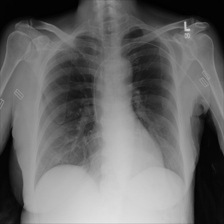

In [28]:
# model_builder = keras.applications.xception.Xception
img_size = (224, 224)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_1"
classifier_layer_names = [
    "dense",
    "flatten",
    "dense_1",
]

img_path = "examples/Effusion_4.png"

display(Image(img_path))

In [29]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

[[8.8406019e-03 7.0580691e-01 6.0189399e-04 7.2272740e-02 1.6120190e-02
  3.2194030e-02 3.2273374e-02 2.2897420e-02 3.9288807e-03 2.1237414e-02
  8.3484892e-03 6.7841515e-02 4.9797222e-03 2.3625318e-03 2.9437352e-04]]
tf.Tensor(1, shape=(), dtype=int64)


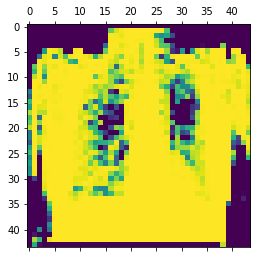

In [31]:
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array(img_path, size=img_size)

img_array = np.mean(img_array, axis=-1)
img_array = img_array[:,:,:,np.newaxis]

prediction = model.predict(img_array)
print(prediction)
print(tf.argmax(prediction[0]))

model = loaded_model

heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

plt.matshow(heatmap)
plt.show()

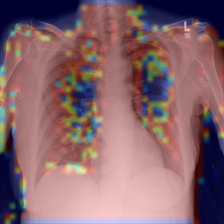

In [32]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

save_path = img_path.split(".")[0] + "gradcam.png"
superimposed_img.save(save_path)

display(Image(save_path))